# <p style="padding: 15px; background-color: #252131; font-family: 'JetBrains Mono'; font-weight: bold; font-size: 100%; color: #f2f2f0; letter-spacing: 2px; text-align: center; border-radius: 8px;">Spaceship Titanic (EDA &amp; ML)</p>

In [1]:
# %load ../initial_settings.py
import os
import shutil
import subprocess
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from colorama import Fore, Style
from IPython.display import display_html
from IPython.core.display import HTML
from matplotlib.patches import PathPatch
from plotly.subplots import make_subplots

from scipy.stats import randint, expon, reciprocal, uniform
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.base import OneToOneFeatureMixin
from sklearn.utils.validation import check_is_fitted
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import mutual_info_classif
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import NuSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RandomizedSearchCV
from sklearn import set_config

# =============================================================================
# Indicates whether the notebook is running on Kaggle or not.
ON_KAGGLE = os.getenv("KAGGLE_KERNEL_RUN_TYPE") is not None

# Here we store models if these are interesting.
MODELS_PATH = Path("models")
MODELS_PATH.mkdir(exist_ok=True)  # If directory exists, do nothing.

CLR = (Style.BRIGHT + Fore.BLACK) if ON_KAGGLE else (Style.BRIGHT + Fore.WHITE)
RED = Style.BRIGHT + Fore.RED
BLUE = Style.BRIGHT + Fore.BLUE
CYAN = Style.BRIGHT + Fore.CYAN
RESET = Style.RESET_ALL

# Matplotlib & Seaborn settings.
FONT_COLOR = "#141B4D"
BACKGROUND_COLOR = "#F6F5F5"
DF_CMAP = sns.light_palette("#3a5a81", as_cmap=True)
MY_RC = {
    "axes.labelcolor": FONT_COLOR,
    "axes.labelsize": 10,
    "axes.labelpad": 15,
    "axes.labelweight": "bold",
    "axes.titlesize": 14,
    "axes.titleweight": "bold",
    "axes.titlepad": 15,
    "xtick.labelsize": 10,
    "xtick.color": FONT_COLOR,
    "ytick.labelsize": 10,
    "ytick.color": FONT_COLOR,
    "figure.titlesize": 14,
    "figure.titleweight": "bold",
    "figure.facecolor": BACKGROUND_COLOR,
    "figure.edgecolor": BACKGROUND_COLOR,
    "figure.dpi": 72,  # Locally Seaborn uses 72, meanwhile Kaggle 96.
    "font.size": 10,
    "font.family": "Serif",
    "text.color": FONT_COLOR,
}

sns.set_theme(rc=MY_RC)

notebook_palette = {
    "graphite_blue": "#26344E",
    "purple_blue1": "#2A357D",
    "purple_blue2": "#454D82",
    "dark_blue1": "#141B4D",
    "dark_blue2": "#0F173B",
    "light_white": "#F2F2F0",
    "light_beige1": "#F6F5F5",
    "light_beige2": "#FFFAF6",
    "orange": "#C73C1A",
    "graphite": "#3E3F4C",
}

# =============================================================================
# Utility functions.
def download_from_kaggle(competition):
    command = "kaggle competitions download -c "
    filepath = Path("data/" + competition + ".zip")

    if not filepath.is_file():
        subprocess.run((command + competition).split())
        Path("data").mkdir(parents=True, exist_ok=True)
        shutil.unpack_archive(competition + ".zip", "data")
        shutil.move(competition + ".zip", "data")


HTML(
    """
<style>
code {
    background: rgba(58, 90, 129, 0.5) !important;
    border-radius: 4px !important;
    color: #f2f2f0 !important;
}
</style>
"""
)


<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color:#252131; 
    padding: 15px; 
    border-radius: 8px;
    border-left: none;
">
<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #f2f2f0;
">
    <b>Competition Description</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #f2f2f0;
    margin-left: 20px;
    margin-right: 20px;
    margin-bottom: 20px;
">
    Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good.</br></br>
    The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.</br></br>
    While rounding Alpha Centauri en route to its first destination - the torrid 55 Cancri E - the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!
</p>

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color:#f2f2f0;
">
    <b>Task</b> 🕵
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #f2f2f0;
    margin-left: 20px;
    margin-right: 20px;
    margin-bottom: 20px;
">
    In this competition your task is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly. To help you make these predictions, you're given a set of personal records recovered from the ship's damaged computer system.
</p>

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #f2f2f0;
">
    <b>This Notebook Covers</b> 📔
</p>

<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #f2f2f0;
    margin-left: 8px;
    margin-right: 8px;
    margin-bottom: 20px;
">
    <li>A quick look at the dataset.</li>
    <li>Heatmap and correlations</li>
    <li>Pivot tables</li>
    <li>Fancy pie charts</li>
    <li>Feature importances</li>
    <li>Model comparison</li>
    <li>Best model tuning and submission</li>
</ul>

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #f2f2f0;
">
    <b>See More Here</b> 📈
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #f2f2f0;
    margin-left: 20px;
    margin-right: 20px;
    margin-bottom: 20px;
">
    <a href="https://www.kaggle.com/competitions/spaceship-titanic/overview" style="color: #3a5a81;"><b>Spaceship Titanic</b></a>
</p>
</blockquote>

# <p style="padding: 15px; background-color: #252131; font-family: 'JetBrains Mono'; font-weight: bold; font-size: 100%; color: #f2f2f0; letter-spacing: 2px; text-align: center; border-radius: 8px;">Dataset General Informations</p>

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #3E3F4C;
    border-bottom: 3px solid #d31336;
">
    <b>Notes</b> 📜
</p>

<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color:#252131; 
    padding: 15px; 
    border-radius: 8px;
    border-left: none;
">
<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #f2f2f0;
    margin-left: 8px;
    margin-right: 8px;
    margin-top: 4px; 
    margin-bottom: 4px;
">
    <li>In this section, we'll look over the dataset in a general manner, i.e. we'll see which attributes are available, which are categorical and numerical, and whether there are any missing values.</li>
    <li>We also glance at features description.</li>
</ul>
</blockquote>


In [2]:
competition = "spaceship-titanic"

if not ON_KAGGLE:
    download_from_kaggle(competition)
    train_path = "data/train.csv"
    test_path = "data/test.csv"
else:
    train_path = f"/kaggle/input/{competition}/train.csv"
    test_path = f"/kaggle/input/{competition}/test.csv"

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #3E3F4C;
    border-bottom: 3px solid #d31336;
">
    <b>Feature Description</b> 📜
</p>

<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color:#252131; 
    padding: 15px; 
    border-radius: 8px;
    border-left: none;
">
<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #f2f2f0;
    margin-left: 8px;
    margin-right: 8px;
    margin-top: 4px; 
    margin-bottom: 4px;
">
    <li><code>PassengerId</code> - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.</li>
    <li><code>HomePlanet</code> - The planet the passenger departed from, typically their planet of permanent residence.</li>
    <li><code>CryoSleep</code> - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.</li>
    <li><code>Cabin</code> - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.</li>
    <li><code>Destination</code> - The planet the passenger will be debarking to.</li>
    <li><code>Age</code> - The age of the passenger.</li>
    <li><code>VIP</code> - Whether the passenger has paid for special VIP service during the voyage.</li>
    <li><code>RoomService</code>, <code>FoodCourt</code>, <code>ShoppingMall</code>, <code>Spa</code>, <code>VRDeck</code> - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.</li>
    <li><code>Name</code> - The first and last names of the passenger.</li>
    <li><code>Transported</code> - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.</li>
</ul>
</blockquote>


In [3]:
train.head()

PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  
0        False  
1         True  
2        False  
3        False  
4         True

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [5]:
categorical = train.select_dtypes("object").columns
numerical = train.select_dtypes("number").columns

print(CLR + "Available Features:\n")

print(
    f"{CLR}CAT:",
    f"{RED}{len(categorical)}",
    f"{BLUE}{list(categorical)}",
    RESET,
)

print(
    f"{CLR}NUM:",
    f"{RED}{len(numerical)}",
    f"{BLUE}{list(numerical)}",
    RESET,
)


Available Features:

CAT: 7 ['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'Name'] 
NUM: 6 ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'] 


In [6]:
train_nans = (
    train.isna()
    .sum()[train.isna().sum() > 0]
    .to_frame(name="Train Missing Values")
    .style.background_gradient(DF_CMAP)
    .set_table_attributes("style='display:inline'")
)

test_nans = (
    test.isna()
    .sum()[test.isna().sum() > 0]
    .to_frame(name="Test Missing Values")
    .style.background_gradient(DF_CMAP)
    .set_table_attributes("style='display:inline'")
)

display_html(train_nans._repr_html_() + test_nans._repr_html_(), raw=True)


Train Missing Values 
 
 
 
 
 HomePlanet 
 201 
 
 
 CryoSleep 
 217 
 
 
 Cabin 
 199 
 
 
 Destination 
 182 
 
 
 Age 
 179 
 
 
 VIP 
 203 
 
 
 RoomService 
 181 
 
 
 FoodCourt 
 183 
 
 
 ShoppingMall 
 208 
 
 
 Spa 
 183 
 
 
 VRDeck 
 188 
 
 
 Name 
 200 
 
 
 

 
 
 
   
 Test Missing Values 
 
 
 
 
 HomePlanet 
 87 
 
 
 CryoSleep 
 93 
 
 
 Cabin 
 100 
 
 
 Destination 
 92 
 
 
 Age 
 91 
 
 
 VIP 
 93 
 
 
 RoomService 
 82 
 
 
 FoodCourt 
 106 
 
 
 ShoppingMall 
 98 
 
 
 Spa 
 101 
 
 
 VRDeck 
 80 
 
 
 Name 
 94

In [7]:
train.describe(percentiles=[0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99]).rename(
    index=str.title
).style.background_gradient(DF_CMAP)


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #3E3F4C;
    border-bottom: 3px solid #d31336;
">
    <b>Notes</b> 📜
</p>

<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color:#252131; 
    padding: 15px; 
    border-radius: 8px;
    border-left: none;
">
<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #f2f2f0;
    margin-left: 8px;
    margin-right: 8px;
    margin-top: 4px; 
    margin-bottom: 4px;
">
    <li>There we have seven categorical features and six numerical including the binary target.</li>
    <li>Each feature contains missing values, but their number is small, usually 1% - 2% of the dataset. Nevertheless, it means we have to build an entire imputation pipeline.</li>
    <li>We have enormous value differences in <code>RoomService</code>, <code>FoodCourt</code>, <code>ShoppingMall</code>, <code>Spa</code>, <code>VRDeck</code>. A few people are probably liable for long tails in these distributions.</li>
</ul>
</blockquote>


# <p style="padding: 15px; background-color: #252131; font-family: 'JetBrains Mono'; font-weight: bold; font-size: 100%; color: #f2f2f0; letter-spacing: 2px; text-align: center; border-radius: 8px;">Correlations &amp; Distributions &amp; Pivot Tables</p>

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #3E3F4C;
    border-bottom: 3px solid #d31336;
">
    <b>Notes</b> 📜
</p>

<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color:#252131; 
    padding: 15px; 
    border-radius: 8px;
    border-left: none;
">
<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #f2f2f0;
    margin-left: 8px;
    margin-right: 8px;
    margin-top: 4px; 
    margin-bottom: 4px;
">
    <li>In this section, we try to look closely at a correlation matrix, we see numerical and categorical feature distributions and pivot tables.</li>
    <li>Let's see the correlation matrix first.</li>
</ul>
</blockquote>


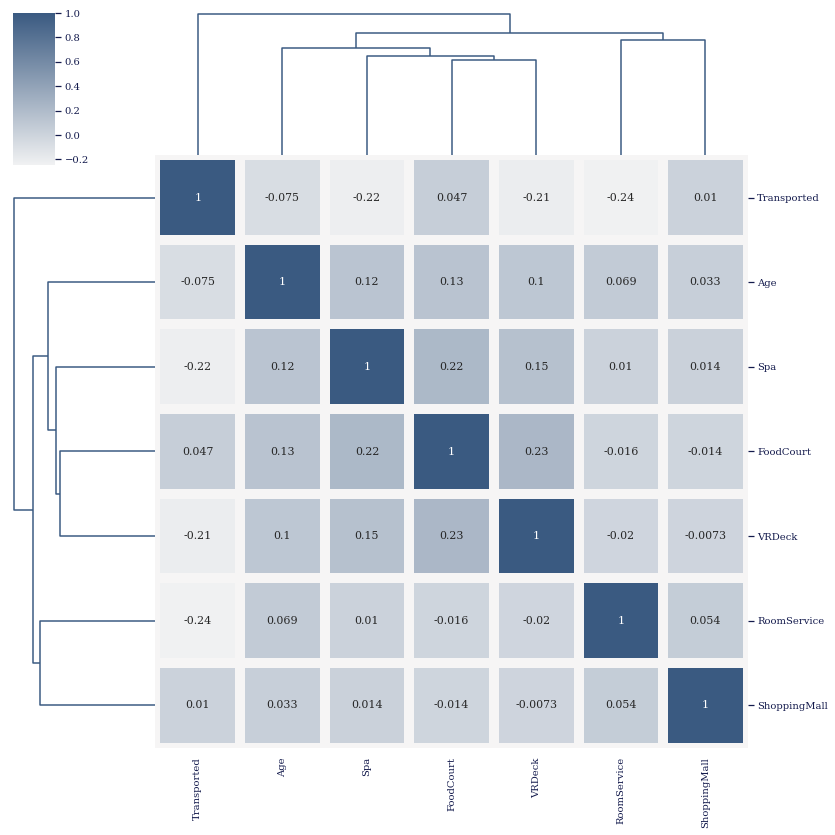

In [8]:
sns.clustermap(
    train.corr(numeric_only=True),
    linecolor=BACKGROUND_COLOR,
    linewidth=10,
    annot=True,
    cmap=DF_CMAP,
    tree_kws={"linewidths": 1.5, "color": "#3a5a81"},
    annot_kws={"fontsize": 11},
    figsize=(11.7, 11.7),
)
plt.show()


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #3E3F4C;
    border-bottom: 3px solid #d31336;
">
    <b>Notes</b> 📜
</p>

<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color:#252131; 
    padding: 15px; 
    border-radius: 8px;
    border-left: none;
">
<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #f2f2f0;
    margin-left: 8px;
    margin-right: 8px;
    margin-top: 4px; 
    margin-bottom: 4px;
">
    <li>At first glance, we don't see anything interesting. If correlations exist, these are small.</li>
    <li>However, several pairs have a value of around $0.2$ or $-0.2$. These are <code>FoodCourt</code> vs <code>VRDeck</code> and <code>FoodCourt</code> vs <code>Spa</code> (positive correlation). Next are <code>Transported</code> vs <code>Spa</code>, <code>Transported</code> vs <code>VRDeck</code> and <code>Transported</code> vs <code>RoomService</code> (negative correlation).</li>
    <li><code>Transported</code> is our label, so travellers who spend more money on different amenities are less prone to be transported to an alternate dimension.</li>
    <li>Now, let's scale these expenditures with log-level transformation to provide plots readability.</li>
</ul>
</blockquote>


In [9]:
amenities_log = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
amenities_map = {amenity: amenity + "Log1p" for amenity in amenities_log}

train_log = train.copy()
train_log.loc[:, amenities_log] = train_log.loc[:, amenities_log].transform(np.log1p)
train_log.rename(columns=amenities_map, inplace=True)
train_log.head()


PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomServiceLog1p  FoodCourtLog1p  ShoppingMallLog1p  SpaLog1p  VRDeckLog1p  \
0          0.000000        0.000000           0.000000  0.000000     0.000000   
1          4.700480        2.302585           3.258097  6.309918     3.806662   
2          3.784190        8.182280           0.000000  8.812248     3.912023   
3          0.000000        7.157735           5.918894  8.110728     5.267858   
4          5.717028        4.262680           5.023881  6.338594     1.098612   

                Name  Transported  
0    Maham Ofracculy        False  
1       Juanna Vines         True  
2      Altark Susent        False  
3       Solam Susent        False  
4  Willy Santantines         True

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #3E3F4C;
    border-bottom: 3px solid #d31336;
">
    <b>Notes</b> 📜
</p>

<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color:#252131; 
    padding: 15px; 
    border-radius: 8px;
    border-left: none;
">
<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #f2f2f0;
    margin-left: 8px;
    margin-right: 8px;
    margin-top: 4px; 
    margin-bottom: 4px;
">
    <li>Let's see the <code>Age</code> distribution and its pivot table.</li>
</ul>
</blockquote>



In [10]:
fig = px.histogram(
    train_log,
    x="Age",
    color="Transported",
    color_discrete_sequence=["#252131", "#D31336"],
    marginal="box",
    barmode="group",
    hover_data=train_log.columns,
    nbins=50,
    height=540,
    width=840,
    title="Travellers - Age Distribution",
)
fig.update_layout(
    font_color=FONT_COLOR,
    title_font_size=18,
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
    bargap=0.2,
    bargroupgap=0.1,
)
fig.show()


In [11]:
agg_func_mapper = {
    "mean": "MeanTransportRate",
    "sum": "TransportedTravellers",
    "count": "GroupSize",
}

age_pivot = (
    train_log.pivot_table(
        values="Transported",
        index=pd.qcut(train_log["Age"], 10),
        aggfunc=["mean", "sum", "count"],
        margins=True,
        margins_name="Total",
    )
    .rename(
        columns=agg_func_mapper,
    )
    .droplevel(level=1, axis="columns")
    .style.background_gradient(DF_CMAP)
)

age_pivot


In [12]:
print(
    f"{CLR}Embryos Onboard:",
    f"{BLUE}{len(train_log.query('Age == 0'))} -",
    f"{BLUE}{len(train_log.query('Age == 0')) / len(train_log):.0%}",
)


Embryos Onboard: 178 - 2%


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #3E3F4C;
    border-bottom: 3px solid #d31336;
">
    <b>Notes</b> 📜
</p>

<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color:#252131; 
    padding: 15px; 
    border-radius: 8px;
    border-left: none;
">
<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #f2f2f0;
    margin-left: 8px;
    margin-right: 8px;
    margin-top: 4px; 
    margin-bottom: 4px;
">
    <li>There we have an interesting insight. As you see, children are more prone to be transported (67% of them have been transported to an alternate dimension).</li>
    <li>We cannot say something similar about the rest since their ratio oscillates around 50%.</li>
    <li>Let's see the distributions of different amenities in a double log scale.</li>
</ul>
</blockquote>


In [13]:
df = train_log.copy()
df["TotalLog1p"] = train.eval(
    "RoomService + FoodCourt + ShoppingMall + Spa + VRDeck"
).transform(np.log1p)

amenities_log = [
    "RoomServiceLog1p",
    "FoodCourtLog1p",
    "ShoppingMallLog1p",
    "SpaLog1p",
    "VRDeckLog1p",
    "TotalLog1p",
]

fig = make_subplots(rows=3, cols=2, y_title="Count", vertical_spacing=0.1)

for cat_feature, (row, col) in zip(
    amenities_log, ((1, 1), (1, 2), (2, 1), (2, 2), (3, 1), (3, 2))
):
    if row == 1 and col == 1:
        showlegend = True
    else:
        showlegend = False

    fig.add_trace(
        go.Histogram(
            x=df.query("Transported == False")[cat_feature],
            name="False",
            nbinsx=15,
            marker=dict(color="#252131"),
            showlegend=showlegend,
        ),
        row,
        col,
    )
    fig.add_trace(
        go.Histogram(
            x=df.query("Transported == True")[cat_feature],
            name="True",
            nbinsx=15,
            marker=dict(color="#D31336"),
            showlegend=showlegend,
        ),
        row,
        col,
    )
    fig.update_xaxes(title_text=cat_feature, row=row, col=col)

fig.update_annotations(font_size=14)
fig.update_layout(
    font_color=FONT_COLOR,
    title="Travellers - Amenity Expenditures",
    title_font_size=18,
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
    bargap=0.2,
    bargroupgap=0.1,
    height=640,
    width=840,
    legend_title="Transported",
)
fig.update_yaxes(type="log")
fig.show()


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #3E3F4C;
    border-bottom: 3px solid #d31336;
">
    <b>Notes</b> 📜
</p>

<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color:#252131; 
    padding: 15px; 
    border-radius: 8px;
    border-left: none;
">
<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #f2f2f0;
    margin-left: 8px;
    margin-right: 8px;
    margin-top: 4px; 
    margin-bottom: 4px;
">
    <li>So, we have many people who didn't spend any money (most of them are probably in cryosleep?).</li>
    <li>Moreover, generally, those who spent more money on different amenities were less prone to be transported.</li>
</ul>
</blockquote>


In [14]:
df["CryoSleep"] = df["CryoSleep"].map(
    {True: "InCryoSleep", False: "NotInCryoSleep"},
)
df["SpendMoney"] = (df["TotalLog1p"] > 0).map(
    {True: "SpendMoney", False: "NotSpendMoney"},
)
df["Transported"] = df["Transported"].map(
    {True: "Transported", False: "NotTransported"},
)
# Sunburst requires non-nan values.
df = df.dropna(subset=["CryoSleep", "SpendMoney", "Transported"])

fig = px.sunburst(
    data_frame=df,
    title="Travellers - CryoSleep vs Spending Money vs Transportation",
    path=["CryoSleep", "SpendMoney", "Transported"],
    color_discrete_sequence=["#252131", "#D31336"],
    height=720,
    width=720,
)
fig.update_traces(
    textinfo="label+percent parent",
    insidetextorientation="horizontal",
    marker_line_width=5,
    marker_line_color=BACKGROUND_COLOR,
)
fig.update_layout(
    font_color=FONT_COLOR,
    title_font_size=18,
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
)
fig.show()


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #3E3F4C;
    border-bottom: 3px solid #d31336;
">
    <b>Notes</b> 📜
</p>

<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color:#252131; 
    padding: 15px; 
    border-radius: 8px;
    border-left: none;
">
<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #f2f2f0;
    margin-left: 8px;
    margin-right: 8px;
    margin-top: 4px; 
    margin-bottom: 4px;
">
    <li>There the sunburst chart is extremely useful. We can see about 36% of people were in cryosleep, and obviously, they didn't spend any money. What is more interesting about 82% of them have been transported to the alternate dimension! It's even more exciting when we look at this group size - about $2500$ travellers.</li>
    <li>On the other side, we have people who were not in cryosleep. About 81% of them spent money on different amenities, and only 30% of travellers in this group have been transported.</li>
    <li>Let's leave numerical features and look at categorical ones.</li>
</ul>
</blockquote>


In [15]:
df = train.copy()

# Four first digits because: "... gggg_pp where gggg indicates a group..."
id_groups = df["PassengerId"].str[:4]
# Only alone passengers have a unique group (thus 1).
df["IsAlone"] = (id_groups.value_counts() == 1).reindex(id_groups).tolist()

df[["CabinDeck", "CabinNum", "CabinSide"]] = df["Cabin"].str.split("/", expand=True)

cat_features = [
    "HomePlanet",
    "CryoSleep",
    "CabinDeck",
    "Destination",
    "VIP",
    "IsAlone",
]

fig = make_subplots(rows=3, cols=2, y_title="Count", vertical_spacing=0.1)

for cat_feature, (row, col) in zip(
    cat_features, ((1, 1), (1, 2), (2, 1), (2, 2), (3, 1), (3, 2))
):
    if row == 1 and col == 1:
        showlegend = True
    else:
        showlegend = False

    fig.add_trace(
        go.Histogram(
            x=df.query("Transported == False")[cat_feature],
            name="False",
            nbinsx=15,
            marker=dict(color="#252131"),
            showlegend=showlegend,
        ),
        row,
        col,
    )
    fig.add_trace(
        go.Histogram(
            x=df.query("Transported == True")[cat_feature],
            name="True",
            nbinsx=15,
            marker=dict(color="#D31336"),
            showlegend=showlegend,
        ),
        row,
        col,
    )
    fig.update_xaxes(title_text=cat_feature, row=row, col=col)

fig.update_annotations(font_size=14)
fig.update_layout(
    font_color=FONT_COLOR,
    title="Travellers - Different Categories",
    title_font_size=18,
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
    bargap=0.2,
    bargroupgap=0.1,
    height=640,
    width=840,
    legend_title="Transported",
)
fig.show()


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #3E3F4C;
    border-bottom: 3px solid #d31336;
">
    <b>Notes</b> 📜
</p>

<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color:#252131; 
    padding: 15px; 
    border-radius: 8px;
    border-left: none;
">
<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #f2f2f0;
    margin-left: 8px;
    margin-right: 8px;
    margin-top: 4px; 
    margin-bottom: 4px;
">
    <li>People from Europa were more prone to be transported, contrary to those from Earth. For people from Mars, the issue is around $50/50$.</li>
    <li>The situation with cryosleep certainly is not a coincidence - most travellers in cryosleep have been transported.</li>
    <li>It's difficult to say something about the cabin deck. We have two puzzling decks here: B and C, but is it a coincidence or maybe something more?</li>
    <li>Destination, IsAlone and VIP are not as exciting as the previous ones. Nevertheless, we see that the VIP attribute should probably be dropped.</li>
    <li>Perhaps the pivot table tells us more.</li>
</ul>
</blockquote>

In [16]:
cat_pivot = (
    train.pivot_table(
        values="Transported",
        index=("CryoSleep", "HomePlanet", "Destination"),
        aggfunc=["mean", "sum", "count"],
        margins=True,
        margins_name="Total",
    )
    .rename(
        columns=agg_func_mapper,
    )
    .droplevel(level=1, axis="columns")
    .style.background_gradient(DF_CMAP)
)

cat_pivot


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #3E3F4C;
    border-bottom: 3px solid #d31336;
">
    <b>Notes</b> 📜
</p>

<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color:#252131; 
    padding: 15px; 
    border-radius: 8px;
    border-left: none;
">
<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #f2f2f0;
    margin-left: 8px;
    margin-right: 8px;
    margin-top: 4px; 
    margin-bottom: 4px;
">
    <li>There we have EDA winners! People who were in cryosleep and travelled from Europa or Mars. Their transportation ratio is extremely high and this cannot be a coincidence!</li>
    <li>Let's see the CryoSleep vs Home Planet vs Transportation sunburst yet.</li>
</ul>
</blockquote>


In [17]:
# Sunburst requires non-nan values.
df = train[["CryoSleep", "HomePlanet", "Transported"]].copy().dropna()
df["CryoSleep"] = df["CryoSleep"].map(
    {True: "InCryoSleep", False: "NotInCryoSleep"},
)
df["Transported"] = df["Transported"].map(
    {True: "Transported", False: "NotTransported"}
)

fig = px.sunburst(
    data_frame=df,
    title="Travellers - CryoSleep vs Home Planet vs Transportation",
    path=["CryoSleep", "HomePlanet", "Transported"],
    color_discrete_sequence=["#252131", "#D31336"],
    height=720,
    width=720,
)
fig.update_traces(
    textinfo="label+percent parent",
    insidetextorientation="horizontal",
    marker_line_width=5,
    marker_line_color=BACKGROUND_COLOR,
)
fig.update_layout(
    font_color=FONT_COLOR,
    title_font_size=18,
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
)
fig.show()


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #3E3F4C;
    border-bottom: 3px solid #d31336;
">
    <b>Notes</b> 📜
</p>

<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color:#252131; 
    padding: 15px; 
    border-radius: 8px;
    border-left: none;
">
<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #f2f2f0;
    margin-left: 8px;
    margin-right: 8px;
    margin-top: 4px; 
    margin-bottom: 4px;
">
    <li>Generally, here we have the same things as in the pivot table (without Destination), but the form is more eye-catchy.</li>
    <li>There are still a lot of things you can do. For example, you can create probability plots to see whether distributions come from the normal one or create a parallel coordinates plot for some features. However, we can play with pivot tables and different plots endlessly, but we know something yet, and we can summarize what to do with available features.</li></br>
    <li><code>PassengerId</code> - Extract groups of family members and create a binary feature - <code>IsAlone</code>.</li>
    <li><code>HomePlanet</code> - Fill in missing values with the most frequent category (Earth). Then apply OneHotEncoder.</li>
    <li><code>CryoSleep</code> - Fill in missing values with the most frequent category (False). Then apply OneHotEncoder.</li>
    <li><code>Cabin</code> - Nothing to do. To be removed at the final stage. Alternatively, extract only the first letter (deck) - <code>CabinDeck</code> and encode with OneHotEncoder.</li>
    <li><code>Destination</code> - Fill in missing values with the most frequent category (TRAPPIST-1e). Then apply OneHotEncoder.</li>
    <li><code>Age</code> - Fill in missing values with the median strategy. Then apply StandardScaler.</li>
    <li><code>VIP</code> - Nothing to do. To be removed at the final stage.</li>
    <li><code>RoomService</code>, <code>FoodCourt</code>, <code>ShoppingMall</code>, <code>Spa</code>, <code>VRDeck</code> - Fill in missing values for passengers in cryosleep with zero. For all others with the median. Then apply log-level transformation and StandardScaler. Additionally, add all these features and create a binary one - <code>SpendMoney</code></li>
    <li><code>Name</code> - Nothing to do. To be removed at the final stage. What is interesting, in the Polish language, we would extract whether someone is a man or a woman, but here it's impossible.</li></br>
    <li>In the next section, we'll prepare an auto-preprocessing pipeline which prepares datasets for machine learning.</li>
</ul>
</blockquote>

# <p style="padding: 15px; background-color: #252131; font-family: 'JetBrains Mono'; font-weight: bold; font-size: 100%; color: #f2f2f0; letter-spacing: 2px; text-align: center; border-radius: 8px;">Preprocessing Pipeline</p>

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #3E3F4C;
    border-bottom: 3px solid #d31336;
">
    <b>Notes</b> 📜
</p>

<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color:#252131; 
    padding: 15px; 
    border-radius: 8px;
    border-left: none;
">
<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #f2f2f0;
    margin-left: 8px;
    margin-right: 8px;
    margin-top: 4px; 
    margin-bottom: 4px;
">
    <li>In this section, we'll build an auto-preprocessing pipeline. To do that, we need two custom classes. One will be responsible for appropriate imputation for numerical attributes like <code>RoomService</code>, <code>FoodCourt</code> etc. The second will be liable for adding new features to the dataset, i.e. <code>SpendMoney</code>, <code>CabinDeck</code> and <code>IsAlone</code>.</li>
</ul>
</blockquote>

In [18]:
class AmenityImputer(BaseEstimator, TransformerMixin, OneToOneFeatureMixin):
    def fit(self, X, y=None):
        """Calculates the median value for all of the amenities and only
        for these passengers who are in CryoSleep."""
        if not isinstance(X, pd.DataFrame):
            raise TypeError("X must be a pandas DataFrame.")

        in_cryo = X["CryoSleep"] == True
        self.amenity_medians_ = {
            "RoomService":  X.loc[~in_cryo, "RoomService"].median(),
            "FoodCourt":    X.loc[~in_cryo, "FoodCourt"].median(),
            "ShoppingMall": X.loc[~in_cryo, "ShoppingMall"].median(),
            "Spa":          X.loc[~in_cryo, "Spa"].median(),
            "VRDeck":       X.loc[~in_cryo, "VRDeck"].median(),
        }

        self.n_features_in_ = X.shape[1]
        self.feature_names_in_ = np.array(X.columns, dtype=object)

        return self

    def transform(self, X, y=None):
        """Returns a new `X` instance with imputed values."""
        if not isinstance(X, pd.DataFrame):
            raise TypeError("X must be a pandas DataFrame.")
        if self.n_features_in_ != X.shape[1]:
            raise ValueError("Unexpected number of features.")
        
        check_is_fitted(self)
        Xc = X.copy()

        in_cryo = Xc["CryoSleep"] == True
        for amenity, median in self.amenity_medians_.items():
            Xc.loc[ in_cryo, amenity] = Xc.loc[ in_cryo, amenity].fillna(0.0)
            Xc.loc[~in_cryo, amenity] = Xc.loc[~in_cryo, amenity].fillna(median)

        return Xc


In [19]:
class FeatureAdder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("X must be a pandas DataFrame.")

        self.amenities_ = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
        self.n_features_in_ = X.shape[1]
        self.feature_names_in_ = np.array(X.columns, dtype=object)

        return self

    def transform(self, X, y=None):
        """Returns a new `X` instance with included additional features."""
        if not isinstance(X, pd.DataFrame):
            raise TypeError("X must be a pandas DataFrame.")
        if self.n_features_in_ != X.shape[1]:
            raise ValueError("Unexpected number of features.")

        check_is_fitted(self)
        Xc = X.copy()

        Xc["SpendMoney"] = Xc[self.amenities_].sum(axis=1) > 0.0
        Xc["CabinDeck"] = Xc["Cabin"].str[0]

        groups = Xc["PassengerId"].str[:4]
        Xc["IsAlone"] = (groups.value_counts() == 1).reindex(groups).tolist()

        return Xc

    def get_feature_names_out(self, input_features=None):
        return np.r_[self.feature_names_in_, ["SpendMoney", "CabinDeck", "IsAlone"]]


In [20]:
preprocess = make_pipeline(
    AmenityImputer(),
    FeatureAdder(),
    make_column_transformer(
        (
            make_pipeline(
                SimpleImputer(strategy="median"),
                StandardScaler(),
            ),
            [
                "Age",
            ],
        ),
        (
            make_pipeline(
                FunctionTransformer(
                    func=np.log1p,
                    inverse_func=np.expm1,
                    feature_names_out="one-to-one",
                ),
                StandardScaler(),
            ),
            [
                "RoomService",
                "FoodCourt",
                "ShoppingMall",
                "Spa",
                "VRDeck",
            ],
        ),
        (
            make_pipeline(
                SimpleImputer(strategy="most_frequent"),
                OneHotEncoder(handle_unknown="ignore"),
            ),
            [
                "HomePlanet",
                "CryoSleep",
                "Destination",
                "SpendMoney",
                "IsAlone",
            ],
        ),
        verbose_feature_names_out=False,
    ),
)

set_config(display="diagram")
preprocess


Pipeline(steps=[('amenityimputer', AmenityImputer()),
                ('featureadder', FeatureAdder()),
                ('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Age']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(feature_name...
                                                                                       inverse_func=<ufunc 'expm1'>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['RoomService', 'FoodCourt',
                                                   'ShoppingMall', 'Spa',
                                                   'VRDeck']),
                                                 ('pipeline-3',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['HomePlanet', 'CryoSleep',
                                                   'Destination', 'SpendMoney',
                                                   'IsAlone'])],
                                   verbose_feature_names_out=False))])

In [21]:
y = train["Transported"]
X = train.drop("Transported", axis=1)

X_full = preprocess.fit_transform(X)
y_full = y

assert np.all(np.isfinite(X_full)) == True
assert np.any(np.isnan(X_full)) == False

feature_names_out = preprocess.get_feature_names_out()
pd.DataFrame(X_full, columns=feature_names_out).head()


Age  RoomService  FoodCourt  ShoppingMall       Spa    VRDeck  \
0  0.711945    -0.644921  -0.658999     -0.627544 -0.675622 -0.649211   
1 -0.334037     1.087749   0.128254      0.643700  1.609909  0.740702   
2  2.036857     0.749990   2.138518     -0.627544  2.516284  0.779172   
3  0.293552    -0.644921   1.788227      1.681889  2.262184  1.274224   
4 -0.891895     1.462464   0.798409      1.332673  1.620296 -0.248078   

   HomePlanet_Earth  HomePlanet_Europa  HomePlanet_Mars  CryoSleep_False  \
0               0.0                1.0              0.0              1.0   
1               1.0                0.0              0.0              1.0   
2               0.0                1.0              0.0              1.0   
3               0.0                1.0              0.0              1.0   
4               1.0                0.0              0.0              1.0   

   CryoSleep_True  Destination_55 Cancri e  Destination_PSO J318.5-22  \
0             0.0                      0.0                        0.0   
1             0.0                      0.0                        0.0   
2             0.0                      0.0                        0.0   
3             0.0                      0.0                        0.0   
4             0.0                      0.0                        0.0   

   Destination_TRAPPIST-1e  SpendMoney_False  SpendMoney_True  IsAlone_False  \
0                      1.0               1.0              0.0            0.0   
1                      1.0               0.0              1.0            0.0   
2                      1.0               0.0              1.0            1.0   
3                      1.0               0.0              1.0            1.0   
4                      1.0               0.0              1.0            0.0   

   IsAlone_True  
0           1.0  
1           1.0  
2           0.0  
3           0.0  
4           1.0

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #3E3F4C;
    border-bottom: 3px solid #d31336;
">
    <b>Notes</b> 📜
</p>

<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color:#252131; 
    padding: 15px; 
    border-radius: 8px;
    border-left: none;
">
<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #f2f2f0;
    margin-left: 8px;
    margin-right: 8px;
    margin-top: 4px; 
    margin-bottom: 4px;
">
    <li>As you see, everything works as it should.</li>
    <li>In the next section, we'll glance at feature importance with LDA, RandomForestClassifier and MutualInformations methods. It answers which attributes are essential and which can probably be neglected.</li>
</ul>
</blockquote>

# <p style="padding: 15px; background-color: #252131; font-family: 'JetBrains Mono'; font-weight: bold; font-size: 100%; color: #f2f2f0; letter-spacing: 2px; text-align: center; border-radius: 8px;">Feature Importances</p>

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #3E3F4C;
    border-bottom: 3px solid #d31336;
">
    <b>Notes</b> 📜
</p>

<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color:#252131; 
    padding: 15px; 
    border-radius: 8px;
    border-left: none;
">
<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #f2f2f0;
    margin-left: 8px;
    margin-right: 8px;
    margin-top: 4px; 
    margin-bottom: 4px;
">
    <li>We need to normalise feature importances from all methods to one in order to compare them.</li>
    <li>Using <code>LDA</code> we need to provide the dataset is normalised too. In this case, the feature importances are based on discriminator weights.</li>
    <li>On the other hand, <code>RandomForestClassifier</code> does not require to scale attributes. Here feature importances are based on Gini impurity decrease.
    <li><code>Mutual Information</code> measures the dependency between variables. It equals zero if two random variables are independent, and higher values mean higher dependency.</li>
</ul>
</blockquote>

In [22]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_full, y_full)
lda_info = np.abs(lda.scalings_.ravel())
lda_info = lda_info / lda_info.sum()

forest = RandomForestClassifier(random_state=42)
forest.fit(X_full, y_full)
forest_info = forest.feature_importances_

mutual_info = mutual_info_classif(X_full, y_full, random_state=42)
mutual_info = mutual_info / np.sum(mutual_info)

importances = pd.DataFrame(
    [lda_info, forest_info, mutual_info],
    columns=feature_names_out,
    index=["LDA", "Random Forest", "Mutual Information"],
).T

importances = importances.loc[
    importances.mean(axis=1).sort_values(ascending=False).index
]

importances.style.background_gradient(DF_CMAP)


In [23]:
melted = (
    importances.melt(var_name="Method", value_name="Importance", ignore_index=False)
    .reset_index()
    .rename(columns={"index": "Feature"})[::-1]
)

fig = px.bar(
    data_frame=melted,
    x="Importance",
    y="Feature",
    color="Method",
    barmode="group",
    height=840,
    width=840,
    color_discrete_sequence=px.colors.sequential.dense_r,
    title="Normalised Feature Importances",
)
fig.update_layout(
    font_color=FONT_COLOR,
    title_font_size=18,
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
    bargroupgap=0.1,
    legend=dict(orientation="h", yanchor="bottom", xanchor="right", y=1.02, x=1),
)
fig.show()


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #3E3F4C;
    border-bottom: 3px solid #d31336;
">
    <b>Notes</b> 📜
</p>

<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color:#252131; 
    padding: 15px; 
    border-radius: 8px;
    border-left: none;
">
<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #f2f2f0;
    margin-left: 8px;
    margin-right: 8px;
    margin-top: 4px; 
    margin-bottom: 4px;
">
    <li>As you see, different methods give different results, but the general trend is rather similar. In each method, a significant contribution is spending money on various amenities.</li>
    <li>In contrast, for some most important is <code>Age</code> or <code>HomePlanet</code>. Therefore it's valuable to give different methods a try.</li>
    <li>In the next section, we will see how different models handle the training dataset.</li>
</ul>
</blockquote>

# <p style="padding: 15px; background-color: #252131; font-family: 'JetBrains Mono'; font-weight: bold; font-size: 100%; color: #f2f2f0; letter-spacing: 2px; text-align: center; border-radius: 8px;">Model Selection</p>

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #3E3F4C;
    border-bottom: 3px solid #d31336;
">
    <b>Notes</b> 📜
</p>

<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color:#252131; 
    padding: 15px; 
    border-radius: 8px;
    border-left: none;
">
<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #f2f2f0;
    margin-left: 8px;
    margin-right: 8px;
    margin-top: 4px; 
    margin-bottom: 4px;
">
    <li>Here we will see different models' baseline accuracy, choose several best options and compare other metrics like Precision, Recall, etc.</li>
</ul>
</blockquote>

In [24]:
skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
baseline_scores = {}
classifiers = (
    LogisticRegression(random_state=42),
    RidgeClassifier(random_state=42),
    SGDClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
    ExtraTreesClassifier(random_state=42),
    GradientBoostingClassifier(random_state=42),
    LinearSVC(random_state=42),
    NuSVC(random_state=42),
    SVC(random_state=42),
    KNeighborsClassifier(),
)

for classifier in classifiers:
    name = classifier.__class__.__name__
    clf_pipeline = make_pipeline(preprocess, classifier)
    baseline_scores[name] = cross_val_score(
        clf_pipeline, X, y, cv=skfold, scoring="accuracy"
    )
    print(CLR + "Training:".ljust(15), f"{BLUE}{name}{RESET}")

Training:       LogisticRegression
Training:       RidgeClassifier
Training:       SGDClassifier
Training:       RandomForestClassifier
Training:       ExtraTreesClassifier
Training:       GradientBoostingClassifier
Training:       LinearSVC
Training:       NuSVC
Training:       SVC
Training:       KNeighborsClassifier


In [25]:
baseline_scores = pd.DataFrame(baseline_scores)
baseline_scores = baseline_scores[baseline_scores.median().sort_values().index]
baseline_desc = (
    baseline_scores.describe().T.drop("count", axis=1).rename(columns=str.title)[::-1]
)
baseline_desc.style.background_gradient(DF_CMAP)

In [26]:
fig = px.box(
    baseline_scores,
    points="all",
    height=540,
    width=840,
    color="variable",
    color_discrete_sequence=px.colors.sequential.thermal,
    labels={"variable": "Classifier", "value": "Accuracy"},
    title="Baseline Accuracy within Stratified 10-Fold CV",
)
fig.update_layout(
    font_color=FONT_COLOR,
    title_font_size=18,
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
)
fig.update_xaxes(tickangle=45)
fig.update_traces(marker={"size": 4})
fig.show()

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #3E3F4C;
    border-bottom: 3px solid #d31336;
">
    <b>Notes</b> 📜
</p>

<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color:#252131; 
    padding: 15px; 
    border-radius: 8px;
    border-left: none;
">
<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #f2f2f0;
    margin-left: 8px;
    margin-right: 8px;
    margin-top: 4px; 
    margin-bottom: 4px;
">
    <li>Here we have the two most promising models - <code>SVC</code> and <code>GradientBoostingClassifier</code>. Let's choose them and see their performance in different metrics.</li>
</ul>
</blockquote>

In [27]:
gbc = make_pipeline(preprocess, GradientBoostingClassifier(random_state=42))
svc = make_pipeline(preprocess, SVC(random_state=42, probability=True))

gbc_scores, svc_scores = {}, {}

for scores, classifier in zip((gbc_scores, svc_scores), (gbc, svc)):
    name = classifier[-1].__class__.__name__
    print(CLR + "Step:".ljust(10), f"{BLUE}{name}{RESET}")

    probabilities = cross_val_predict(
        classifier, X, y, cv=skfold, method="predict_proba"
    )
    positive_class_proba = probabilities[:, 1]
    predictions = np.argmax(probabilities, axis=1)

    scores["Classifier"] = name
    scores["Accuracy"] = accuracy_score(y, predictions)
    scores["Precision"] = precision_score(y, predictions)
    scores["Recall"] = recall_score(y, predictions)
    scores["Specificity"] = recall_score(y, predictions, pos_label=0)
    scores["F1"] = f1_score(y, predictions)
    scores["ConfusionMatrix"] = confusion_matrix(y, predictions)
    scores["ROC-AUC"] = roc_auc_score(y, positive_class_proba)
    scores["FPR-TPR-Threshold"] = roc_curve(y, positive_class_proba)


Step:      GradientBoostingClassifier
Step:      SVC


In [28]:
metrics = pd.DataFrame(
    {
        gbc_scores["Classifier"]: [
            gbc_scores["Accuracy"],
            gbc_scores["Precision"],
            gbc_scores["Recall"],
            gbc_scores["Specificity"],
            gbc_scores["F1"],
            gbc_scores["ROC-AUC"],
        ],
        svc_scores["Classifier"]: [
            svc_scores["Accuracy"],
            svc_scores["Precision"],
            svc_scores["Recall"],
            svc_scores["Specificity"],
            svc_scores["F1"],
            svc_scores["ROC-AUC"],
        ],
    },
    index=["Accuracy", "Precision", "Recall", "Specificity", "F1", "ROC-AUC"],
)

metrics.T.style.background_gradient(DF_CMAP)


In [29]:
fig = px.bar(
    metrics,
    height=540,
    width=840,
    labels={"variable": "Classifier", "value": "Value", "index": "Metric"},
    title="SVC vs GradientBoostingClassifier - Metrics Summary",
    color="variable",
    barmode="group",
    color_discrete_sequence=["#252131", "#D31336"],
)
fig.update_layout(
    font_color=FONT_COLOR,
    title_font_size=18,
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
    bargap=0.4,
    bargroupgap=0.1,
    legend=dict(orientation="h", yanchor="bottom", xanchor="right", y=1.02, x=1),
)
fig.show()


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #3E3F4C;
    border-bottom: 3px solid #d31336;
">
    <b>Notes</b> 📜
</p>

<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color:#252131; 
    padding: 15px; 
    border-radius: 8px;
    border-left: none;
">
<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #f2f2f0;
    margin-left: 8px;
    margin-right: 8px;
    margin-top: 4px; 
    margin-bottom: 4px;
">
    <li>We can see even fight but in favour of <code>GradientBoostingClassifier</code>, so it will be our final model.</li>
    <li>The last thing we need to do is model tuning.</li>
</ul>
</blockquote>

# <p style="padding: 15px; background-color: #252131; font-family: 'JetBrains Mono'; font-weight: bold; font-size: 100%; color: #f2f2f0; letter-spacing: 2px; text-align: center; border-radius: 8px;">Final Model Tuning &amp; Submission</p>

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #3E3F4C;
    border-bottom: 3px solid #d31336;
">
    <b>Notes</b> 📜
</p>

<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color:#252131; 
    padding: 15px; 
    border-radius: 8px;
    border-left: none;
">
<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #f2f2f0;
    margin-left: 8px;
    margin-right: 8px;
    margin-top: 4px; 
    margin-bottom: 4px;
">
    <li>In this section, we'll tune the <code>GradientBoostingClassifier</code>. To do so, we'll use a randomized search. </li>
</ul>
</blockquote>

In [30]:
def print_search_info(search_instance, space=55):
    name = search_instance.best_estimator_[-1].__class__.__name__
    print(CLR + "name:".ljust(space), f"{BLUE}{name}{RESET}")
    print(CLR + "best_score:".ljust(space), f"{BLUE}{search_instance.best_score_}{RESET}")
    for hyperparameter, value in search_instance.best_params_.items():
        print(CLR + f"{hyperparameter}:".ljust(space), f"{BLUE}{value}{RESET}")

In [31]:
gbc_final = make_pipeline(
    preprocess,
    GradientBoostingClassifier(random_state=42),
)

gbc_final_space = {
    "gradientboostingclassifier__n_estimators": (100, 200, 300),
    "gradientboostingclassifier__learning_rate": reciprocal(0.005, 0.5),
    "gradientboostingclassifier__max_depth": randint(3, 6),
    "gradientboostingclassifier__min_samples_split": randint(16, 64),
    "gradientboostingclassifier__min_samples_leaf": randint(8, 32),
    "gradientboostingclassifier__max_features": (4, 6, 8, 10),
    "gradientboostingclassifier__subsample": (0.3, 0.4, 0.5),
}

gbc_final_search = RandomizedSearchCV(
    estimator=gbc_final,
    param_distributions=gbc_final_space,
    cv=skfold,
    n_iter=50,
    n_jobs=-1,
    scoring="accuracy",
    random_state=42,
)

gbc_final_search.fit(X, y)
print_search_info(gbc_final_search)


name:                                                   GradientBoostingClassifier
best_score:                                             0.7965010647725619
gradientboostingclassifier__learning_rate:              0.023824817710692576
gradientboostingclassifier__max_depth:                  5
gradientboostingclassifier__max_features:               8
gradientboostingclassifier__min_samples_leaf:           23
gradientboostingclassifier__min_samples_split:          31
gradientboostingclassifier__n_estimators:               300
gradientboostingclassifier__subsample:                  0.4


In [32]:
# Let's see the final pipeline.
set_config(display="diagram")
gbc_final_search.best_estimator_


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('amenityimputer', AmenityImputer()),
                                 ('featureadder', FeatureAdder()),
                                 ('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('standardscaler',
                                                                                    StandardScaler())]),
                                                                   ['Age']),
                                                                  ('pipeline-2',
                                                                   Pipeline(steps=[('functiontransformer',
                                                                                    Func...
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   ['HomePlanet',
                                                                    'CryoSleep',
                                                                    'Destination',
                                                                    'SpendMoney',
                                                                    'IsAlone'])],
                                                    verbose_feature_names_out=False))])),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(learning_rate=0.023824817710692576,
                                            max_depth=5, max_features=8,
                                            min_samples_leaf=23,
                                            min_samples_split=31,
                                            n_estimators=300, random_state=42,
                                            subsample=0.4))])

In [33]:
sumbission = pd.DataFrame(
    {
        "PassengerId": test["PassengerId"],
        "Transported": gbc_final_search.best_estimator_.predict(test),
    }
).set_index("PassengerId")

sumbission.to_csv("submission.csv")
sumbission.head()


Transported
PassengerId             
0013_01             True
0018_01            False
0019_01             True
0021_01             True
0023_01             True

# <p style="padding: 15px; background-color: #252131; font-family: 'JetBrains Mono'; font-weight: bold; font-size: 100%; color: #f2f2f0; letter-spacing: 2px; text-align: center; border-radius: 8px;">Summary</p>

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #3E3F4C;
    border-bottom: 3px solid #d31336;
">
    <b>Notes</b> 📜
</p>

<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color:#252131; 
    padding: 15px; 
    border-radius: 8px;
    border-left: none;
">
<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #f2f2f0;
    margin-left: 8px;
    margin-right: 8px;
    margin-top: 4px; 
    margin-bottom: 4px;
">
    <li>We conducted a quick exploratory data analysis for the Spaceship Titanic dataset.</li>
    <li>We showed several interesting graphics like cluster maps, feature distributions, pie charts, feature importances and boxplots.</li>
    <li>Next, we studied some basic classifiers and chose the most promising ones.</li>
    <li>Lastly, we tuned <code>GradientBoostingClassifier</code>, which won over <code>SVC</code> in different metrics like Recall, F1, etc.</li>
    <li>If you like my work and visualisations, then upvote. I appreciate that. Moreover, you can look over my other notebooks. Maybe you find something useful there.</li>
</ul>
</blockquote>